In [0]:
%pip install tensorflow==1.15

In [0]:
%pip install keras.self.attention

Processing /root/.cache/pip/wheels/7b/05/a0/99c0cf60d383f0494e10eca2b238ea98faca9a1fe03cac2894/keras_self_attention-0.42.0-cp36-none-any.whl


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd drive/My\ Drive/Music\ Generation

[Errno 2] No such file or directory: 'drive/My Drive/Music Generation'
/content/drive/My Drive/Music Generation


In [0]:
%ls

data/
midi_songs/
weights-1LSTMAtt1LSTMLayer-001-6.2803.hdf5
weights-1LSTMAtt1LSTMLayer-002-6.0968.hdf5
weights-1LSTMAtt1LSTMLayer-003-5.9649.hdf5
weights-1LSTMAtt1LSTMLayer-004-5.8101.hdf5
weights-1LSTMAtt1LSTMLayer-005-5.6262.hdf5
weights-1LSTMAtt1LSTMLayer-006-5.4096.hdf5
weights-1LSTMAtt1LSTMLayer-007-5.1715.hdf5
weights-1LSTMAtt1LSTMLayer-008-4.9074.hdf5
weights-1LSTMAtt1LSTMLayer-009-4.6201.hdf5
weights-1LSTMAtt1LSTMLayer-010-4.3009.hdf5
weights-1LSTMAtt1LSTMLayer-011-3.9533.hdf5
weights-1LSTMAtt1LSTMLayer-012-3.5862.hdf5
weights-1LSTMAtt1LSTMLayer-013-3.2294.hdf5
weights-1LSTMAtt1LSTMLayer-014-2.8439.hdf5
weights-1LSTMAtt1LSTMLayer-015-2.4786.hdf5
weights-1LSTMAtt1LSTMLayer-016-2.1437.hdf5
weights-1LSTMAtt1LSTMLayer-017-1.8519.hdf5
weights-1LSTMAtt1LSTMLayer-018-1.5559.hdf5
weights-1LSTMAtt1LSTMLayer-019-1.3120.hdf5
weights-1LSTMAtt1LSTMLayer-020-1.1104.hdf5
weights-1LSTMAtt1LSTMLayer-021-0.9453.hdf5
weights-1LSTMAtt1LSTMLayer-022-0.8136.hdf5
weights-1LSTMAtt1LSTMLayer-023-0.683

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os

import glob
import pickle

from music21 import converter, instrument, stream, note, chord

#Run version 2.1.6
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Activation, Bidirectional, Flatten
from keras import utils
from keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention

# Training

In [0]:
def train_network(notes, n_vocab):
    """ Train a Neural Network to generate music """
    network_input, network_output = prepare_sequences(notes, n_vocab)

    model = create_network(network_input, n_vocab)

    history = train(model, network_input, network_output)

    return model, history

In [0]:
def get_notes():
    """ Get all the notes and chords from the midi files in the ./full_set_beethoven_mozart directory. Call BEFORE train """
    notes = []
    durations = []

    for file in glob.glob("midi_songs/*.mid"):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi) #Change to only grab the piano???
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch) + " " +  str(element.quarterLength))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder) + " " + str(element.quarterLength))
            elif isinstance(element, note.Rest):
                notes.append(str(element.name)  + " " + str(element.quarterLength))

    with open('data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [0]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = utils.to_categorical(network_output)

    return (network_input, network_output)

In [0]:
def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(Bidirectional(CuDNNLSTM(512,
        input_shape=(network_input.shape[1], network_input.shape[2]), #n_time_steps, n_features?
        return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.3))
    
    model.add(CuDNNLSTM(512,return_sequences=True))
    model.add(Dropout(0.3))
    
    model.add(Flatten()) #Supposedly needed to fix stuff before dense layer
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

def train(model, network_input, network_output):
    """ train the neural network """
    filepath = os.path.abspath("weights-1LSTMAtt1LSTMLayer-{epoch:03d}-{loss:.4f}.hdf5")
    checkpoint = ModelCheckpoint(
        filepath,
        period=1, #Every 10 epochs
        monitor='loss',
        verbose=1,
        save_best_only=False,
        mode='min'
    )
    callbacks_list = [checkpoint]

    return model.fit(network_input, network_output, epochs=100, batch_size=64, callbacks=callbacks_list)

In [0]:
#load files in
notes = get_notes()

# get amount of pitch names
n_vocab = len(set(notes))

Parsing midi_songs/8.mid
Parsing midi_songs/ahead_on_our_way_piano.mid
Parsing midi_songs/0fithos.mid
Parsing midi_songs/AT.mid
Parsing midi_songs/BlueStone_LastDungeon.mid
Parsing midi_songs/balamb.mid
Parsing midi_songs/caitsith.mid
Parsing midi_songs/bcm.mid
Parsing midi_songs/braska.mid
Parsing midi_songs/Cids.mid
Parsing midi_songs/costadsol.mid
Parsing midi_songs/cosmo.mid
Parsing midi_songs/dayafter.mid
Parsing midi_songs/decisive.mid
Parsing midi_songs/dontbeafraid.mid
Parsing midi_songs/DOS.mid
Parsing midi_songs/Eternal_Harvest.mid
Parsing midi_songs/EyesOnMePiano.mid
Parsing midi_songs/electric_de_chocobo.mid
Parsing midi_songs/FF3_Third_Phase_Final_(Piano).mid
Parsing midi_songs/FF3_Battle_(Piano).mid
Parsing midi_songs/ff1battp.mid
Parsing midi_songs/ff11_awakening_piano.mid
Parsing midi_songs/ff4-airship.mid
Parsing midi_songs/ff4-town.mid
Parsing midi_songs/ff4-fight1.mid
Parsing midi_songs/Ff4-BattleLust.mid
Parsing midi_songs/ff4_piano_collections-main_theme.mid
Parsin

In [0]:
#train
model, history = train_network(notes, n_vocab) 

Epoch 1/100
65277/65277 [==============================] - 125s 2ms/step - loss: 6.2803 - accuracy: 0.0798

Epoch 00001: saving model to /content/drive/My Drive/Music Generation/weights-1LSTMAtt1LSTMLayer-001-6.2803.hdf5
Epoch 2/100
65277/65277 [==============================] - 124s 2ms/step - loss: 6.0968 - accuracy: 0.0819

Epoch 00002: saving model to /content/drive/My Drive/Music Generation/weights-1LSTMAtt1LSTMLayer-002-6.0968.hdf5
Epoch 3/100
65277/65277 [==============================] - 123s 2ms/step - loss: 5.9649 - accuracy: 0.0889

Epoch 00003: saving model to /content/drive/My Drive/Music Generation/weights-1LSTMAtt1LSTMLayer-003-5.9649.hdf5
Epoch 4/100
65277/65277 [==============================] - 123s 2ms/step - loss: 5.8101 - accuracy: 0.0987

Epoch 00004: saving model to /content/drive/My Drive/Music Generation/weights-1LSTMAtt1LSTMLayer-004-5.8101.hdf5
Epoch 5/100
65277/65277 [==============================] - 124s 2ms/step - loss: 5.6262 - accuracy: 0.1121

Epoch 00

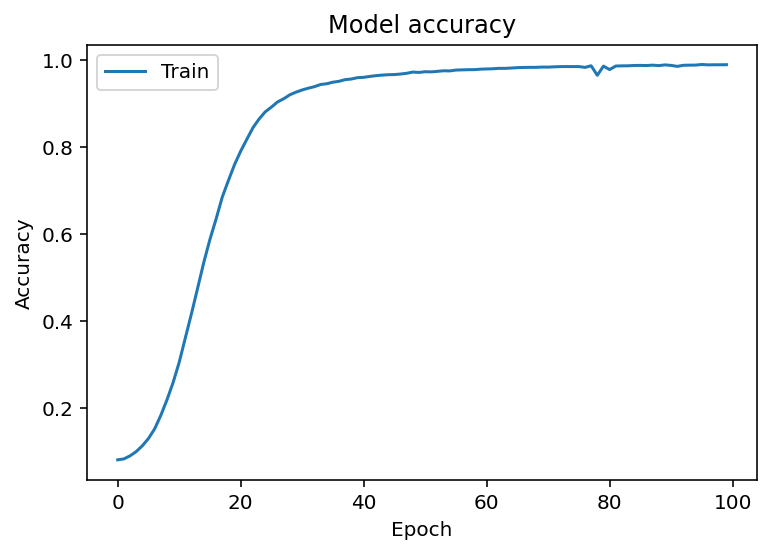

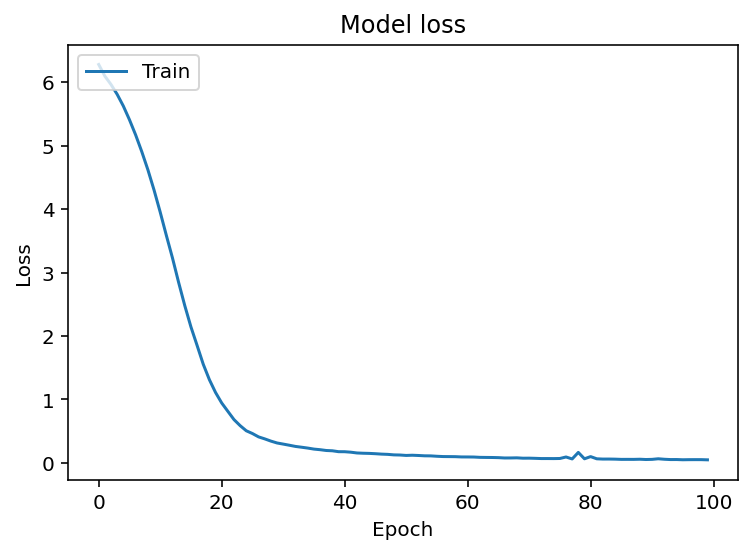

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Prediction

In [0]:
def generate():
    """ Generate a piano midi file """
    #load the notes used to train the model
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    network_input, normalized_input = prepare_sequences_output(notes, pitchnames, n_vocab)
    model = create_network_add_weights(normalized_input, n_vocab)
    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
    create_midi(prediction_output)

In [0]:
def prepare_sequences_output(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

In [0]:
def create_network_add_weights(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(Bidirectional(CuDNNLSTM(512,
        return_sequences=True),input_shape=(network_input.shape[1], network_input.shape[2])))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.3))
    
    model.add(CuDNNLSTM(512,return_sequences=True))
    model.add(Dropout(0.3))
    
    model.add(Flatten()) #Supposedly needed to fix stuff before dense layer
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    # Load the weights to each node
    model.load_weights('weights-1LSTMAtt1LSTMLayer-031-0.2969.hdf5')
    
    return model

In [0]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [0]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        pattern = pattern.split()
        temp = pattern[0]
        duration = pattern[1]
        pattern = temp
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = instrument.Piano() #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output.mid')
 
#From: https://stackoverflow.com/questions/1806278/convert-fraction-to-float
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

In [0]:
#RUN THE GENERATOR

generate()